In this notebook I will demonstrate Sky Detection and the calculation of SVF (Sky View Factor).

The idea behind SVF is that you want to have a view of the sky as if you were projecting it on a dome and looking at the dome from the center of It (A planetarium type of thing). This is called a fisheye representation of the image. Once you have that you compute the SVF as the ratio of sky pixels to the total pixels of the image. 

I have a proof of the formulas (old habits from the faculty of sciences). I might upload that as a complement later on, for now I will just state the steps for calculating the SVF.


We start with a panoramic image $P_{ij}$ of width $W$ and height $H$.

1. Segment the sky on the panoramic image, generating a binary mask $S_{ij}$ of height $H$ and width $W$.

2. Create a mold for your fisheye image $F_{i'j'}$ initialize it as a square grid of width and height equal to $r_{0}$. I have found that $r_{0} = 1000$ works ok. The center of the image is $(x_{fc},y_{fc}) = (r_{0}/2, r_{0}/2)$

3. Iterate over all positions $i', j'$ in the fisheye mold. We will assign to $F_{i'j'}$ a value of the segmented sky panoramic $S_{ij}$, the corresponding row $i$ and column $j$ to look for in the panoramic is given by the following equations:

\begin{align}
    j &= \frac{W}{2\pi} \arctan\left( \frac{i' - y_{fc}}{j' - x_{fc}} \right) \\
    i &= \frac{H}{r_0} \sqrt{(j' - x_{fc})^2 + (i' - y_{fc})^2}
\end{align}

where you might need to apply rounding operations of course.

4. That's it, once you have filled the $F_{ij}$ mold you can simply compute the $SVF$ as:

\begin{equation}
SVF = \frac{\sum_{i}\sum_{j} F{ij}}{r_{0}^2}
\end{equation}


Let's demonstrate the analysis. This is all really encapsulated in the SVFCalculator. 

### Sky segmentation

First I will show how to segment sky on a panoramic. 

In [14]:
from alivestreets.streetview_collection.streetview_collection import StreetViewImageCollector
import os
import matplotlib.pyplot as plt

api_key = ""


#Collect the image
image_collector = StreetViewImageCollector(
    api_key
)

latitude = 34.10314604457623
longitude = -118.32669756849636
heading_angle = 90
pitch = 0
output_dir = os.path.join(os.getcwd(),"data", "panoramic_view_2")

image, metadata = image_collector.collect_panoramic_with_views(
    latitude,
    longitude,
    output_dir
)

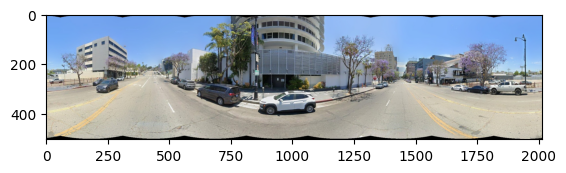

In [39]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

image = np.array(Image.open(os.path.join(os.getcwd(),"data", "panoramic_view_2", "panoramic.jpg")))
plt.figure()
plt.imshow(image)

In [40]:
#Let's show the segmented sky
from alivestreets.features.svf_feature import SVFFeatureExtractor
from alivestreets.visualization.mask_visualization import TransparentMaskVisualizer
import cv2

svf_extractor = SVFFeatureExtractor()
svf_extractor.download_model()


Model downloaded.


The sky view factor is 0.25


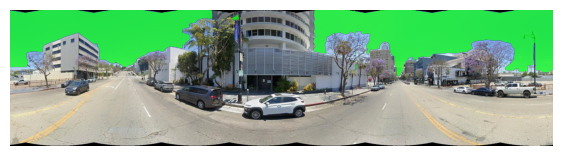

In [41]:
svf_extractor.confidence_threshold = 0.3
results = svf_extractor.compute(cv2.imread(os.path.join(os.getcwd(),"data", "panoramic_view_2", "panoramic.jpg")))
mask = results["sky_mask"]

visualizer = TransparentMaskVisualizer()
visualizer.visualize(
    image,
    [mask],
    [""],
    colors = ["#00ff00"], 
    alpha = 0.7
)
print(f"The sky view factor is {results['SVF']:.2f}")

### Tagging SVF over a network

Let's obtain the SVF around capitol records. I think it should be quite high since its California. 

Exported: data/network_3.geojson
270


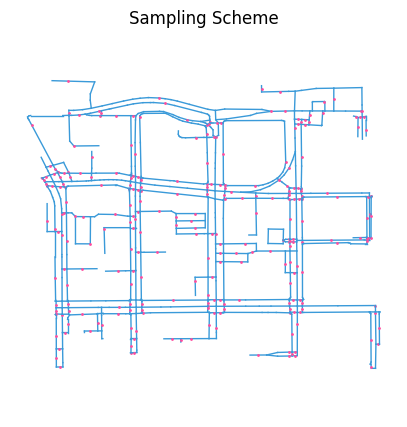

In [1]:
from alivestreets.network import network_retrieval
#I am going to use a small area because we are taking 8 images per point. 
radius = 300
lat = 34.10314604457623
lon = -118.32669756849636

graph = network_retrieval.get_graph_from_point(lat, lon, radius)
network_path = "data/network_3.geojson"
network_retrieval.export_graph_geojson(graph, network_path)

from alivestreets.sampling.street_sampler import StreetSampler
street_sampler = StreetSampler(100)
street_sampler.open_streets("data/network_3.geojson")
street_sampler.sample_streets_no_intersections()
street_sampler.draw_sampling_scheme(width = 5, height = 5)

print(len(street_sampler.get_all_sampling_points()))

In [4]:
from alivestreets.streetview_collection.streetview_network_collection import StreetViewNetworkCollector
import os

api_key = ""
network_image_collector = StreetViewNetworkCollector(
    "full_panoramics",
    api_key)

output_path_images = os.path.join(os.getcwd(), "data", "network_images_panoramics")

point_dictionaries = network_image_collector.collect_street_sampler_images(
    street_sampler,
    output_path_images
)


100%|██████████| 270/270 [1:16:11<00:00, 16.93s/it]


In [21]:
#Open the point dictionaries
import json
output_path_images = os.path.join(os.getcwd(), "data", "network_images_panoramics")
point_dictionaries = []
with open(os.path.join(output_path_images, "point_dictionaries.jsonl"), "r") as f:
    for line in f:
        point_dictionaries.append(json.loads(line.strip()))

#Obtain the SVF values
from tqdm import tqdm 
svf_values = []
for point_dict in tqdm(point_dictionaries):
    svf_extractor.confidence_threshold = 0.3
    results = svf_extractor.compute(cv2.imread(point_dict["panoramic_view_path"]))
    svf_values.append(results["SVF"])

100%|██████████| 270/270 [08:10<00:00,  1.82s/it]


In [22]:
street_sampler.tag_streets(
    "SVF",
    svf_values,
    method = "mean"
)

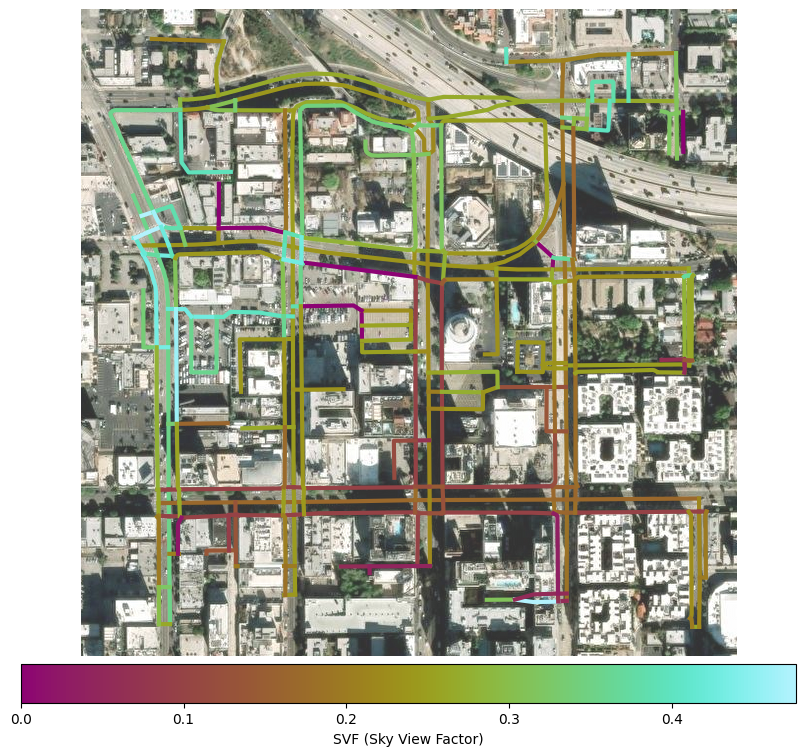

In [36]:
from alivestreets.visualization.map_visualizer import MapVisualizer
import cmcrameri.cm as cmc
map_visualizer = MapVisualizer()
map_visualizer.initialize_map(figsize = (10,10))
map_visualizer.add_street_sampler(
    street_sampler,
    "SVF",
    "continuous",
    cmap = cmc.hawaii,
    edge_width = 3
)
map_visualizer.draw_networks(
    colorbar_label = "SVF (Sky View Factor)", 
    colorbar_orientation = "horizontal",
    min_percentile = 1,
    max_percentile = 99, 
    )

map_visualizer.add_basemap(
    alpha = 0.8,
    tile_url = "https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}")
map_visualizer.finalize_map()